In [ ]:
# Data cleaning

In [1]:
# Clean the data file by removing non-text (e.g. emojis, smart quotes) and regularizing text 
#(e.g. tokenization, lower casing, stemming, lemmatizing, POS tagging, stop word removal, removing punctuation, spelling correction)
import demoji
import json
import spacy
from spacy.lang.en import English
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer

path= "faqsFromPdf.json"
with open(path, 'r') as json_file:
    text = json.load(json_file)

categories = []
all_text = ""
for key, faq_list in text.items():
    group_text = ""

    for faq_item in faq_list:
        all_text += faq_item["question"] + " " + faq_item["answer"] + " "
        group_text += faq_item["question"] + faq_item["answer"] 
    categories.append(group_text)

# Removing emojis
clean_text = demoji.replace(all_text,"")
#remove smart quotes
clean_text = clean_text.replace("“", "\"").replace("”","\"")
# convert text to lower-case
clean_text = clean_text.lower()

spell = SpellChecker()
stemmer = PorterStemmer()

# Find and correct spelling errors
corrected_text = []
clean_text=clean_text.split()
for word in clean_text:
    # Check if the word is misspelled
    if spell.unknown([word]):
        # Get the corrected version of the word
        corrected_word = spell.correction(word)
        # Check if the corrected word is not None
        if corrected_word is not None:
            corrected_text.append(corrected_word)
        else:
            # If the correction is None, keep the original word
            corrected_text.append(word)
    else:
        corrected_text.append(word)
# Join the corrected words back into a string
corrected_text = " ".join(corrected_text)   

#Tokenzing using Spacy with removing white spaces, stop words, and punctuations
nlp = spacy.load('en_core_web_sm')
doc = nlp(corrected_text)

# Lemmatize and stem the words
lemmatized_and_stemmed_words = []
for token in doc:
    lemma = token.lemma_
    stem = stemmer.stem(token.text)  # Use Porter Stemmer
    lemmatized_and_stemmed_words.append((token.text, lemma, stem))

clean_words = [token.text for token in doc if not (token.is_space or token.is_stop or token.is_punct)]
posArray = [(token.text, token.pos_) for token in doc if not (token.is_space or token.is_stop or token.is_punct)]

# print(clean_words)
with open("cleaned_data.txt", "w", encoding='utf-8') as txt_file:
     txt_file.write(str(clean_words))

In [ ]:
# Generate additional training data for the project by substituting different words with the same superordinate term in different sentence patterns. 

In [3]:
# get the WordNet list of all housing

import nltk
from nltk.corpus import wordnet as wn
wn.synsets('housing')

[Synset('housing.n.01'),
 Synset('housing.n.02'),
 Synset('caparison.n.01'),
 Synset('house.v.01'),
 Synset('house.v.02')]

In [4]:
print(wn.synset('housing.n.01').definition())
print(wn.synset('housing.n.02').definition())

structures collectively in which people are housed
a protective cover designed to contain or support a mechanical component


In [5]:
word_list = wn.synset('housing.n.01').hyponyms()
simple_names = []
for word in range (len(word_list)):
    simple_name = word_list[word].lemma_names()[0]
    simple_names.append(simple_name)
print(simple_names)

['apartment', 'billet', 'block', 'camp', 'condominium', 'dwelling', 'hospice', 'hostel', 'living_quarters', 'mobile_home', 'pied-a-terre', 'quartering', 'rattrap', 'shelter', 'tract_housing']


In [24]:
# generate some sample data

text_frame = "Can I sign up for one semester of "
for vegetable in range(len(simple_names)):
    print(text_frame + simple_names[vegetable])

Can I sign up for one semester of apartment
Can I sign up for one semester of billet
Can I sign up for one semester of block
Can I sign up for one semester of camp
Can I sign up for one semester of condominium
Can I sign up for one semester of dwelling
Can I sign up for one semester of hospice
Can I sign up for one semester of hostel
Can I sign up for one semester of living_quarters
Can I sign up for one semester of mobile_home
Can I sign up for one semester of pied-a-terre
Can I sign up for one semester of quartering
Can I sign up for one semester of rattrap
Can I sign up for one semester of shelter
Can I sign up for one semester of tract_housing


In [ ]:
# Performing context-free grammars and parsing 

In [125]:
# an NLTK CFG grammar 
grammar = nltk.CFG.fromstring("""
S -> Event Verb Predicate
Event -> 'Orientation' | 'Graduation' | 'Homecoming'
Verb -> 'is'
Predicate -> NP Prep Det Adj Noun Location
NP -> Det Adj Noun
VP -> Verb NP  
PP -> Prep NP
Det -> 'a' || 'all'
Prep -> 'for'
Adj -> 'required' | 'new'
Noun -> 'event' | 'students' | 'activities'
Location -> 'living' 'on' 'and' 'off-campus'
""")

1
(S
  (Event Orientation)
  (Verb is)
  (Predicate
    (NP (Det a) (Adj required) (Noun event))
    (Prep for)
    (Det all)
    (Adj new)
    (Noun students)
    (Location living on and off-campus)))


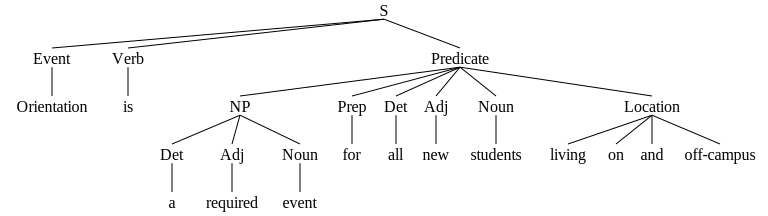

In [126]:
# parse and visualize a sentence
# we will need this to tokenize the input
import nltk
from nltk import word_tokenize
# a package for visualizing parse trees
import svgling
# to use svgling we need to disable NLTK's normal visualization functions
svgling.disable_nltk_png()
# example sentence that can be parsed with the grammar we've defined
sent = nltk.word_tokenize("Orientation is a required event for all new students living on and off-campus")
# create a chart parser based on the grammar above
parser = nltk.ChartParser(grammar)
# parse the sentence
trees = list(parser.parse(sent))
print(len(trees))
# print a text-formatted parse tree
print(trees[0])
# print an SVG formatted parse tree
trees[0]

In [ ]:
# slot filling and slot visualization

In [135]:
import spacy
from spacy.lang.en import English

nlp = English()

ruler = nlp.add_pipe("entity_ruler")
university_patterns = [
    {"label": "UNIVERSITY", "pattern": "pacific"},
    {"label": "UNIVERSITY", "pattern": "uop"},
    {"label": "UNIVERSITY", "pattern": "university"},
    {"label": "UNIVERSITY", "pattern": "uopi"}]
department_patterns = [
    {"label": "DEPARTMENT", "pattern": "school of business"},
    {"label": "DEPARTMENT", "pattern": "school of engineering and computer science "},
    {"label": "DEPARTMENT", "pattern": "school of dentistry"}]
occupation_patterns = [
    {"label": "OCCUPATION", "pattern": "part-time"},
    {"label": "OCCUPATION", "pattern": "full-time"},
    {"label": "OCCUPATION", "pattern": "student job"},
    {"label": "OCCUPATION", "pattern": "internship"},
    {"label": "OCCUPATION", "pattern": "internships"},
    {"label": "OCCUPATION", "pattern": "freelancer"},
    {"label": "OCCUPATION", "pattern": "teaching assistant"},
    {"label": "OCCUPATION", "pattern": "researcher"},
    {"label": "OCCUPATION", "pattern": "tutor"}]

service_patterns = [
    {"label": "SERVICE", "pattern": "career resource center"},
    {"label": "SERVICE", "pattern": "career services"},
    {"label": "SERVICE", "pattern": "academic advising"},
    {"label": "SERVICE", "pattern": "library services"},
    {"label": "SERVICE", "pattern": "counseling services"},
   {"label": "SERVICE", "pattern": "counseling services"}]
location_patterns = [
     {"label": "LOCATION", "pattern": "on campus"},
     {"label": "LOCATION", "pattern": "off campus"},
     {"label": "LOCATION", "pattern": "stockton, california"},
     {"label": "LOCATION", "pattern": "san francisco, california"},
     {"label": "LOCATION", "pattern": "sacramento, california"}]
           
ruler.add_patterns(university_patterns)
ruler.add_patterns(department_patterns)
ruler.add_patterns(occupation_patterns)
ruler.add_patterns(service_patterns)
ruler.add_patterns(location_patterns)
text = "Many students choose to work part-time while attending Pacific.Our Career Resource Center can help you find jobs and paid internships, or you can search for yourself on Handshake, Pacific’s online job and opportunity board. It’s easy and common for students to find work on campus – get your resume drafted up and make an appointment at Career Services to get started!"
text = text.lower()
doc = nlp(text)
print([(ent.text, ent.label_) for ent in doc.ents])


[('part-time', 'OCCUPATION'), ('career resource center', 'SERVICE'), ('internships', 'OCCUPATION'), ('pacific', 'UNIVERSITY'), ('on campus', 'LOCATION'), ('career services', 'SERVICE')]


In [136]:
from spacy import displacy
colors = {"UNIVERSITY": "#ea7e7e",
          "DEPARTMENT": "#baffc9",
          "OCCUPATION": "#abcdef",
          "SERVICE": "#ffffba",
          "LOCATION":"dfffba"}
options = {"ents": ["UNIVERSITY","DEPARTMENT","OCCUPATION","SERVICE","LOCATION"], "colors": colors}
displacy.render(doc, style="ent", options=options,jupyter = True)